In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from transformers import BertTokenizer, BertModel

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import os


In [2]:
# Load the CSV file
df = pd.read_csv("data/Fake.csv")

# Get the number of rows in the CSV file
n_rows = len(df)

# Sample 20% of the rows randomly
sample_size = int(n_rows * 0.2)
random_indices = np.random.choice(n_rows, sample_size, replace=False)

# Create a new CSV file with the sampled rows
df_sample = df.iloc[random_indices]
df_sample.to_csv("data/fake_test_20.csv", index=False)

# Save the rest of the rows into a new CSV file
df_rest = df.loc[~df.index.isin(random_indices)]
df_rest.to_csv("data/fake_train_80.csv", index=False)

In [3]:
# Load the CSV file
df = pd.read_csv("data/Real.csv")

# Get the number of rows in the CSV file
n_rows = len(df)

# Sample 20% of the rows randomly
sample_size = int(n_rows * 0.2)
random_indices = np.random.choice(n_rows, sample_size, replace=False)

# Create a new CSV file with the sampled rows
df_sample = df.iloc[random_indices]
df_sample.to_csv("data/real_test_20.csv", index=False)

# Save the rest of the rows into a new CSV file
df_rest = df.loc[~df.index.isin(random_indices)]
df_rest.to_csv("data/real_train_80.csv", index=False)

In [ ]:
# Load the data
df_real = pd.read_csv("data/real_train_80.csv") 
df_fake = pd.read_csv("data/fake_train_80.csv")

# Add labels to the datasets
df_fake['isReal'] = 0  # add label
df_real['isReal'] = 1  # add label

# Concatenate real and fake news
df = pd.concat([df_real, df_fake]).reset_index(drop = True)
df.head()

,title,text,subject,date,isReal
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
3,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1
4,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1


In [ ]:
# Check if the dataset is class-unbalanced or not
print( df['isReal'].value_counts() )
print()
if 0.9 < (df['isReal'].value_counts()[0] / df['isReal'].value_counts()[1]) < 1.1:
  print('Dataset is class-balanced')
else:
  print('Dataset is class-unbalenced')

isReal
0    18785
1    17134
Name: count, dtype: int64

Dataset is class-balanced


In [10]:
# Combine title and text together
df['combine'] = df['title'] + ' ' + df['text']
# Shuffle the dataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Download stopwords
nltk.download("stopwords")

# Endlish stopwords
stop_words = stopwords.words('english')
stop_words[:10]

# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

# Apply the function to the dataframe
df['clean'] = df['combine'].apply(preprocess)

# Join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


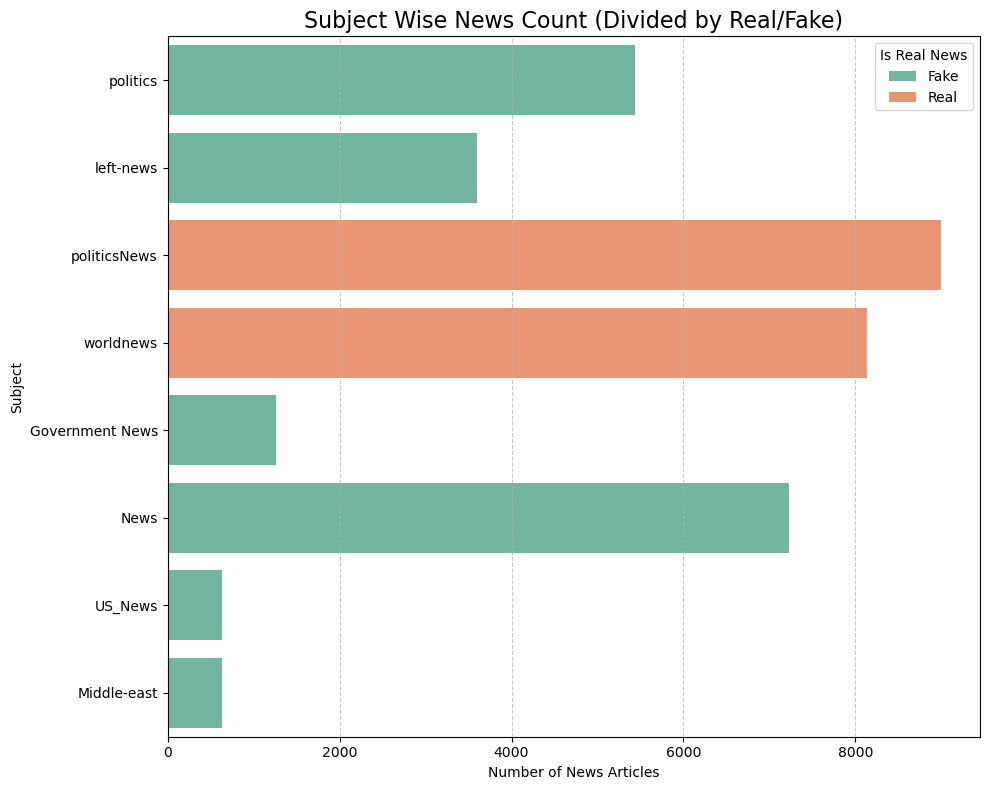

In [ ]:
# Plot the number of samples in each subject
plt.figure(figsize=(10, 8))
plt.title("Subject Wise News Count (Divided by Real/Fake)", fontsize=16)

# hue="isReal" splits the bars between real (1) and fake (0)
sns.countplot(y="subject", data=df, hue="isReal", palette="Set2")

plt.xlabel("Number of News Articles")
plt.ylabel("Subject")
plt.legend(title="Is Real News", labels=["Fake", "Real"])
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
# Drop the 'subject' column as it has a strong correlation with the label
df = df.drop(columns=['subject'])
